# Motivation
This notebook analyses the spreadsheet containing information on the reversals. This spreadsheet collects different features on the trades in an attempt of creating a binary classifier, this classifier will learn from the data collected and will predict the value of the `outcome` variable, which can be success of failre

# Data
The data has been collected in an spreadsheet containing trades both simulated and real. And the different trades have been classified into three types: continuation, counter and ranging. The independent variables gathered for each trade type are:
## Continuation trades
* id = string, id used in the screenshot folder to identify this record
* start = datetime (in the format: 26/05/2009 22:00:00), start of this trade
* timeframe = string, possible values are 2D,D,H12,H8
* entry = float, entry price
* outcome = string, possible values are S=success;F=failure;B=breakeven.Outcome of the trace
* RSI bounces = integer. Number of RSI bounces ocurring in the trend before entry
* No of candles = integer. How many candles before occurred the bounce, from the entry of trade to the first bounce (without counting the entry candle)
* entry on RSI = boolean. True= Entry on oversold/overbought region, False= Entry NOT on oversold/overbought region
* length of trend = integer. Length of the preceding trend in number of candles. The valley before the continuation is not included in the count
* strong trend = boolean. True if the trend is strong, otherwise is False
* trend angle = integer. Angle of the trend
* bounce length = integer. Length in number of candles for each of the bounces (in the order from the most recent to the oldest)
* retraced = integer. Only relevant when outcome is 'F', how many pips from the S/L the trade reversed?. If n.a., then it means that the trade did not reversed
* last time = datetime (in the format 26/05/2009), last time that the price was below/above this level

## Dependencies

In [201]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

# Continuation trades

First, let's create a function to read-in a .csv file containing the data andstore it in a dataframe:

In [202]:
def read_tradedata(tradefile,sep,na_values):
    '''
    Parameters
    ----------
    tradefile : str, required
                Path to file containing the trade data
    sep : str, optionsl
          Field separator used in the file. i.e. ',' (comma separated values), '\t' (tab-separated values)
    na_values : list, optional
                Additional list of strings to recognize as NA/NaN. i.e. ['n.a.']
    
    Returns
    -------
    A Pandas dataframe
    '''
    DF=pd.read_csv(tradefile,sep=sep,na_values=na_values)
    
    return DF

contDF=read_tradedata('/Users/ernesto/Downloads/Screenshot analysis - continuations.csv',sep=",",na_values=["n.a.","n.a"])

contDF.shape

(54, 16)

And some information about contDF:

In [203]:
contDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 16 columns):
id                         54 non-null object
start                      51 non-null object
timeframe                  51 non-null object
entry                      51 non-null float64
outcome                    54 non-null object
Candle +1 against trade    54 non-null bool
RSI bounces                54 non-null int64
No of candles              49 non-null object
bounce length              49 non-null object
entry on RSI               54 non-null bool
length of trend            54 non-null int64
strong trend               54 non-null bool
trend angle                51 non-null float64
retraced                   18 non-null float64
last time                  52 non-null object
target                     3 non-null object
dtypes: bool(3), float64(3), int64(2), object(8)
memory usage: 5.7+ KB


## Initial exploration of the data

First things first, let's examine if we have a significant number of records per category of the dependent variable (outcome in this case), since it is really very important to have enough records to establish solid conclusions

In [204]:
contDF['outcome'].value_counts()

S    28
F    23
B     3
Name: outcome, dtype: int64

For now I am not going to consider the trades having an outcome of 'B'. So, let's remove them from the dataframe:

In [205]:
contDF=contDF[contDF.outcome != 'B']

### Candle +1 against trade
This variable is True when the IC+1 is against the trade. I will here analyze the influence of this variable on the outcome

Let's create a contigency table analysing the relationship between these 2 variables:

In [206]:
div_class=pd.crosstab(contDF['outcome'], contDF['Candle +1 against trade'],margins=True)
print(div_class)

Candle +1 against trade  False  True  All
outcome                                  
F                           14     9   23
S                           24     4   28
All                         38    13   51


It's is easier to visualize the relationship if we calculate the percentages:

In [207]:
prop=(div_class/div_class.loc["All"])*100
print(prop)

Candle +1 against trade       False        True         All
outcome                                                    
F                         36.842105   69.230769   45.098039
S                         63.157895   30.769231   54.901961
All                      100.000000  100.000000  100.000000


* Conclusion <br>
Within the trades with IC+1 against the trade there are {{'%.1f' % prop.iloc[0, 1]}}% of failures and {{'%.1f' % prop.iloc[1, 1]}}% of successes<br>
Within the trades with IC+1 in favour of the trade there are {{'%.1f' % prop.iloc[0, 0]}}% of failures and {{'%.1f' % prop.iloc[1, 0]}}% of successes

###  RSI bounces
Let's examine if there is a correlation between the number of bounces and the outcome of the trade

As an initial exploration I will create a boxplot displaying the data

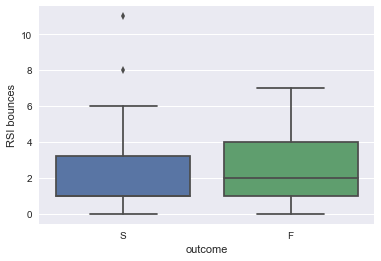

In [208]:
ax = sns.boxplot(x="outcome", y="RSI bounces", data=contDF)

* Mean for each category

In [209]:
contDF.groupby(['outcome']).agg({'RSI bounces': 'mean'})

,RSI bounces
outcome,
F,2.608696
S,2.535714


* Median for each category

In [210]:
medianBounce=contDF.groupby(['outcome']).agg({'RSI bounces': 'median'})
print(medianBounce)

         RSI bounces
outcome             
F                  2
S                  1


* Conclusion <br>
The median number of bounces for successful trades is {{'%.0f' % medianBounce.iloc[1,0]}}<br>
The median number of bounces for failed trades is {{'%.0f' % medianBounce.iloc[0,0]}}<br>

* Distribution of the number of bounces
For this particular task I will create a count plot in order to plot the RSI bounces for both the successful and the failed trades

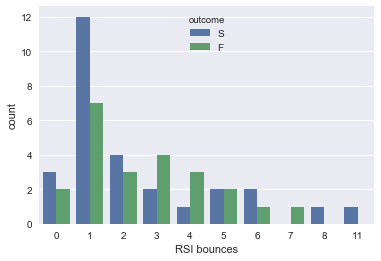

In [211]:
ax = sns.countplot(x="RSI bounces",hue="outcome", data=contDF)

### retraced
This integer variable represents the number of pips from the S/L from where the failing trade retraced and hitted the target. Let's start analyzing the number of trades that retraced:

In [212]:
len(contDF[contDF.retraced !='n.a.'])

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/pandas/core/ops.py:816: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

Now, let's examine the distribution of the data:

In [ ]:
ret=contDF[contDF.retraced !='n.a.'].retraced.astype(int)
ret.plot(kind="box")

In [ ]:
print(ret.describe())

### No of candles
This variable represents the number of candles since the beginning of the trade until the first RSI bounce. I am going compare the distribution of this variable depending on the `outcome` variable.<br>
First, I will convert this variable to an int32

In [213]:
contDF[['No of candles']]=contDF[['No of candles']].astype(int)

ValueError: cannot convert float NaN to integer

As an initial exploration I will create a boxplot displaying the data:

In [ ]:
ax = sns.boxplot(x="outcome", y="No of candles", data=contDF)